<a href="https://colab.research.google.com/github/Krankile/ensemble_forecasting/blob/main/lstm_vae_m4_training_varlen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture
!pip install wandb kora

import wandb
from kora import drive

wandb.login()
drive.link_nbs()

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWh7b_i63KxgAP-HbyGT15Jx9FTNc6kseM-7vOwP2f3CFx3rrV_G7g0


In [2]:
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/12 – Master, Ankile og Krange")

In [3]:
knownhosts = ROOT / "Keys"

In [4]:
%%capture
!mkdir ~/.ssh/
!cp -r "{knownhosts}/"* ~/.ssh/
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

In [5]:
%%capture
!cat /root/.ssh/id_rsa.pub

In [17]:
%%capture
!git clone "git@github.com:Krankile/ensemble_forecasting.git"
!cd ensemble_forecasting && git pull

In [27]:
import os
import copy
import random
from datetime import datetime as dt
import psutil
from collections import defaultdict
from pathlib import Path
import json
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.optim import lr_scheduler

from torch.nn.utils.rnn import pack_sequence, pack_padded_sequence, pad_packed_sequence, pad_sequence, PackedSequence

import ensemble_forecasting
from ensemble_forecasting.models.lstm_ae import model_versions
from ensemble_forecasting.utils.normalizers import normalizers
from ensemble_forecasting.utils.optimizers import optimizers

plt.rcParams["figure.figsize"] = (16, 8)

DATA_ROOT = ROOT / "Data"

reload(ensemble_forecasting.models)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
model_versions

{'RecurrentAutoencoderV2': ensemble_forecasting.models.lstm_ae.RecurrentAutoencoderV2,
 'RecurrentAutoencoderV3': ensemble_forecasting.models.lstm_ae.RecurrentAutoencoderV3,
 'RecurrentAutoencoderV4': ensemble_forecasting.models.lstm_ae.RecurrentAutoencoderV4}

In [8]:
!nvidia-smi

Tue Nov 23 09:56:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Define data functions

### Variable sequence length

#### Load and prepare

In [9]:
class VectorizeData(Dataset):
    def __init__(self, df_path, maxlen=500, nexamples=None, normalize="minmax"):
        self.maxlen = maxlen
        data = pd.read_feather(df_path).set_index("st").iloc[:nexamples, :]
         
        self.index = data.index.values

        self.lens = data.n.to_list()
        data = data.drop(columns=["n", "type", "period"]).to_numpy()
        self.clamped_lens = torch.IntTensor(self.lens).clamp(max=maxlen)
        self.normalize = normalize
        self.data = self.pad_data(data)

    def pad_data(self, series):
        mlen = self.maxlen
        norm = normalizers[self.normalize]

        data = np.zeros((series.shape[0], mlen, 1), dtype=np.float32)

        for i, (l, s) in enumerate(zip(self.lens, series)):
            l = min(mlen, l)
            s = s[max(0, l-mlen):l]
            s = s.reshape((-1, 1))

            s = norm()(s)
            
            data[i, :l] = s

        return data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx]
        lens = self.clamped_lens[idx]
        index = self.index[idx]
        return x, lens, index

In [10]:
def get_dataloaders(run, train_path, val_path, test_path=None):
    conf = run.config
    cpus = psutil.cpu_count()

    print(f"Using {cpus} CPUs in dataloaders")
    
    train_data = VectorizeData(train_path, maxlen=conf.maxlen, nexamples=conf.n_train, normalize=conf.normalize_data)
    val_data = VectorizeData(val_path, maxlen=conf.maxlen, nexamples=conf.n_val, normalize=conf.normalize_data)

    train_loader = DataLoader(train_data, batch_size=conf.batch_size, shuffle=True, num_workers=cpus, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=conf.batch_size, shuffle=False, num_workers=cpus, pin_memory=True)

    seq_len, num_features = conf.maxlen, 1

    if test_path is not None:
        test_data = VectorizeData(test_path, maxlen=conf.maxlen, normalize=conf.normalize_data)
        test_loader = DataLoader(test_data, batch_size=conf.batch_size, shuffle=True, num_workers=cpus, pin_memory=True)

        return train_loader, val_loader, test_loader, seq_len, num_features    

    return train_loader, val_loader, seq_len, num_features

## Define plotting functions

In [11]:
def plot(ax, d1, d2, idx):
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.plot(d1, label=f'Original')
    ax.plot(d2, label=f'Reconstructed')
    ax.legend()

def plot_examples(figurepath,
                  data1,
                  example_packed,
                  model,
                  lens,
                  epoch,
                  conf,
                  rows=3,
                  cols=3,
                  size=(16, 8),
                  show=False,):
    data2 = pad_packed_sequence(model(example_packed.to(device), lens), batch_first=True, total_length=conf.maxlen)[0].detach().cpu().numpy()
    plt.style.use('seaborn-pastel')
    figs = np.array(range(rows*cols)).reshape((rows, cols))
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=size)
    meta = {
        "epoch": epoch,
        "ed": conf.embedding_dim,
        "hd": conf.hidden_dim,
        "drop": conf.dropout,
        "opt": conf.optimizer,
        "batch": conf.batch_size,
        "maxlen": conf.maxlen,
        "normal": conf.normalize_data,
    }
    
    fig.suptitle(f"Results on val data ({meta})", size=14)

    idx = 0

    for rfig, rdat in zip(axs, figs):
        for ax, r in zip(rfig, rdat):
            plot(ax, data1[r], data2[r], idx=idx)
            # plot(ax, data1[r][:lens[r]], data2[r][:lens[r]], idx=idx)
            idx += 1

    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    
    plt.savefig(figurepath)
    if not show:
        plt.close(fig)

## Define training helper functions

In [12]:
def early_stop(hi, ma1=5, ma2=20, em=1.05):
    val_ma1 = np.mean(hi["val"][-ma1:])
    val_ma2 = np.mean(hi["val"][-ma2:])*em
    
    if val_ma2 < val_ma1 and hi["val"][-1] > hi["train"][-1]:
        return True

    return False

## Define training loop

In [13]:
def train_model(model, train_loader, val_loader, conf):

    optimizer = optimizers[conf.optimizer](model.parameters(), lr=conf.learning_rate, weight_decay=conf.weight_decay)
    criterion = nn.L1Loss(reduction="mean").to(device)
    scheduler = lr_scheduler.ExponentialLR(optimizer, conf.scheduler_decay_rate)

    scaler = torch.cuda.amp.GradScaler()


    best_loss = float("inf")
    b_size = conf.batch_size
    step = 0
    example_data, example_lens, _ = next(iter(val_loader))
    example_packed = pack_padded_sequence(example_data, example_lens, batch_first=True, enforce_sorted=False)
    history = dict(train=[], val=[])

    it = tqdm(range(1, conf.epochs + 1))
    for epoch in it:
        
        # Training part of epoch
        model = model.train()
        train_losses = []
        for seq_true, lens, _ in train_loader:
            optimizer.zero_grad()
            packed_true = pack_padded_sequence(seq_true, lens, batch_first=True, enforce_sorted=False).to(device)
            seq_true = seq_true.to(device)

            with torch.cuda.amp.autocast():
                seq_pred = model(packed_true, lens)
                loss = criterion(seq_pred.data, packed_true.data)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())

            step += 1

        # Validation part of epoch
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true, lens, _ in val_loader:
                seq_true = seq_true.to(device)
                packed_true = pack_padded_sequence(seq_true, lens, batch_first=True, enforce_sorted=False).to(device)
                seq_pred = model(packed_true, lens)
                
                loss = criterion(seq_pred.data, packed_true.data)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        scheduler.step()

        history["train"].append(train_loss)
        history["val"].append(val_loss)

        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch, "examples": step*b_size, "lr": optimizer.param_groups[0]["lr"]}, step=step)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            filepath = "model.torch"
            torch.save(best_model_wts, filepath)
            wandb.save(filepath)

            figurepath = "best_val_plot.png"
            plot_examples(
                figurepath,
                example_data,
                example_packed,
                model,
                lens=example_lens,
                epoch=epoch,
                conf=conf,
            )
            wandb.log({"best_val_expl": wandb.Image(figurepath), "epoch": epoch}, step=step)

        if (epoch + 1) % 10 == 0:
            figurepath = "periodic_val_plot.png"
            plot_examples(
                figurepath,
                example_data,
                example_packed,
                model,
                lens=example_lens,
                epoch=epoch,
                conf=conf,
            )
            wandb.log({"periodic_val_expl": wandb.Image(figurepath), "epoch": epoch}, step=step)


        it.set_postfix(
            train_loss=train_loss,
            val_loss=val_loss,
            lr=f"{optimizer.param_groups[0]['lr']:.2e}",
        )

        # Code for early stopping
        if conf.early_stop and early_stop(history, ma1=5, ma2=20, em=1.05):
            wandb.log({"early_stop": True, "epoch": epoch}, step=step)
            break

    model.load_state_dict(best_model_wts)
    return model.eval(), filepath

## Run training

### Setup and start training loop

In [31]:
def train(config=None, project=None, entity=None, enablewb=True):
    mode = "online" if enablewb else "disabled"
    with wandb.init(config=config, project=project, entity=entity, job_type="training", mode=mode) as run:
        conf = wandb.config

        train_path = DATA_ROOT / "Series/m4_series_n4_f32_train.feather"
        val_path = DATA_ROOT / "Series/m4_series_n4_f32_val.feather"

        (train_loader,
         val_loader,
         seq_len,
         n_features) = get_dataloaders(run, train_path, val_path)

        model = model_versions[conf.architecture](
            seq_len=seq_len,
            n_features=n_features,
            embedding_dim=conf.embedding_dim,
            hidden_dim=conf.hidden_dim,
            dropout=conf.dropout,
            num_layers=conf.num_layers,
        )

        print(f"Moving model {conf.architecture} to device: {device}")
        model = model.to(device)

        model, savepath = train_model(
            model,
            train_loader,
            val_loader,
            conf=conf,
        )

        artifact = wandb.Artifact(conf.architecture, type='lstm-ae-model', metadata={"config": json.dumps(dict(conf))})
        # Add a file to the artifact's contents
        artifact.add_file(savepath)
        # Save the artifact version to W&B and mark it as the output of this run
        run.log_artifact(artifact)
    return model
    

### Standalone training

#### Config

In [32]:
config = dict(
    epochs=1_000,
    n_train=100_000,
    n_val=10_000,
    embedding_dim=32,
    hidden_dim=128,
    learning_rate=0.01,
    architecture="RecurrentAutoencoderV4",
    num_layers=3,
    batch_size=2*2048,
    optimizer="adamw",
    dropout=0.2,
    variable_len=True,
    maxlen=2_000,
    early_stop=False,
    normalize_data="minmax",
    weight_decay=0.01,
    scheduler="ExponentialLR",
    scheduler_decay_rate=0.995,
)

#### Start

In [ ]:
enablewb = True
sweep = False
sweepid = "krankile/lstm-vae/4hwgg3ba"

if sweep:
    count = 100 # number of runs to execute
    wandb.agent(sweepid, function=train, count=count)
else:
    model = train(config=config, project="lstm-vae", entity="krankile", enablewb=enablewb)

Using 4 CPUs in dataloaders
Moving model RecurrentAutoencoderV4 to device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

## Generate features from trained network

In [ ]:
root = "/content/drive/MyDrive/## Master, Ankile og Krange/"

runpath = "Models/211107_lstm_n50k_hd64/"
modelpath = root + runpath + "model.torch"
configpath = root + runpath + "config.yaml"

train_path = root + "Data/Series/m4_series_n4_f32_train.feather"
val_path = root + "Data/Series/m4_series_n4_f32_val.feather"
test_path = root + "Data/Series/m4_series_n4_f32_test.feather"

params = dict(
    config=configpath,
    project="lstm-vae",
    entity="krankile",
    job_type="generate_features",
    mode="disabled",
)

with wandb.init(**params) as run:

    wandb.config.update({
        "n_train": 100_000,
        "n_val": 10_000,
    }, allow_val_change=True)

    conf = run.config
    (train_loader,
     val_loader,
     test_loader,
     seq_len,
     n_features) = get_dataloaders(run, train_path, val_path, test_path)

     loaders = dict(
         train=train_loader,
         val=val_loader,
         test=test_loader,
     )

    model = RecurrentAutoencoder2(
        seq_len=seq_len,
        n_features=n_features,
        embedding_dim=conf.embedding_dim,
        hidden_dim=conf.hidden_dim,
        dropout=conf.dropout,
    )
    
    print(modelpath)
    model.load_state_dict(torch.load(modelpath))

    encoder = model.eval().encoder
    print(encoder)

    features = defaultdict(list)
    idxs = defaultdict(list)

    with torch.no_grad():
        for setname, loader in loaders.items():
            for seq_true, lens, idx in tqdm(loader, desc=f"Processing {setname} data"):
                    packed_true = pack_padded_sequence(seq_true, lens, batch_first=True, enforce_sorted=False)
                    feat = encoder(packed_true)
                    features[setname].append(feat)
                    idxs[setname].extend(idx)

for setname in tqdm(loaders, desc="Writing sets to files"):
    # Set the batches together
    fs = torch.cat(features[train_loader], dim=0).squeeze(1).cpu().numpy()

    # Write files
    df = pd.DataFrame(fs, index=idxs[train_loader], columns=[f"lstm_{i}" for i in range(fs.shape[1])])
    df.reset_index().to_feather(root + f"Data/lstm-features/lstm-features-100k-{setname}.feather")
    df.reset_index().to_csv(root + f"Data/lstm-features/lstm-features-100k-{setname}.csv")


Shape of dataset: (90000, 1000, 1)
Shape of dataset: (9995, 1000, 1)
/content/drive/MyDrive/## Master, Ankile og Krange/Models/211107_lstm_n50k_hd64/model.torch
Encoder2(
  (lstm1): LSTM(1, 64, proj_size=32, num_layers=2, batch_first=True, dropout=0.12728007430864388)
)


100%|██████████| 40/40 [00:07<00:00,  5.42it/s]


In [ ]:
with wandb.init(config=config, project="lstm-vae", entity="krankile", job_type="generate_features", mode="disabled") as run:
    # train_loader, val_loader, seq_len, num_features = get_dataloaders_traval(run, traindata, valdata)

    features = []
    idxs = []

    with torch.no_grad():
        for seq_true, lens, _, idx in tqdm(train_loader):
                packed_true = pack_padded_sequence(seq_true, lens, batch_first=True, enforce_sorted=False).to(device)
                feat, _ = model(packed_true)
                features.append(feat)
                idxs.extend(idx)
    


100%|██████████| 20/20 [00:00<00:00, 22.65it/s]


In [ ]:
fs = torch.cat(features, dim=0).squeeze(1).cpu().numpy()

df = pd.DataFrame(fs, index=idxs, columns=[f"lstm_{i}" for i in range(fs.shape[1])])
df.reset_index().to_feather(root + "Data/lstm-features.feather")

## Visualize the model itself

In [ ]:
model = RecurrentAutoencoder(
    seq_len=1000,
    n_features=1,
    embedding_dim=32,
    hidden_dim=64,
    dropout=0.13,
)

print(model)

RecurrentAutoencoder(
  (encoder): Encoder2(
    (lstm1): LSTM(1, 64, proj_size=32, num_layers=2, batch_first=True, dropout=0.13)
  )
  (decoder): Decoder2(
    (rnn1): LSTM(32, 64, proj_size=1, num_layers=2, batch_first=True)
  )
)


## Check results

In [ ]:
filepath = f"modelsaves/model-{conf.dataset}.torch"
print(filepath)
model.load_state_dict(torch.load(filepath))

model = model.eval().cpu()

modelsaves/model-droso-sine-noise-v01.torch


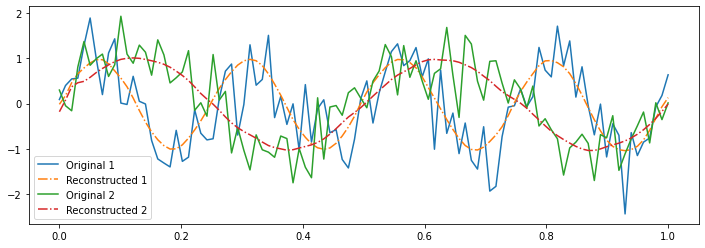

In [ ]:
series = 2

for n, i in enumerate(range(0, series), start=1):
    plt.plot(np.linspace(0, 1, 100), train_tensor[i], label=f"Original {n}");
    plt.plot(
        np.linspace(0, 1, 100),
        model(train_tensor[i]).reshape((-1)).detach().numpy(),
        label=f"Reconstructed {n}",
        linestyle="-."
    )
plt.legend();

# Archive

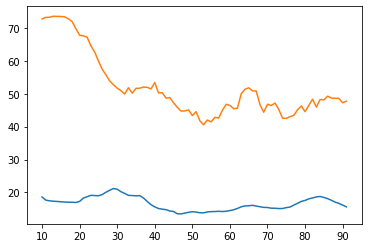

In [ ]:
# Plot training data
logspath = "/content/drive/MyDrive/# 9. Semester/Prosjektoppgave_runs-logs-2021-10-20 15:58:18.177512"

logs = pd.read_csv(logspath, sep=";").set_index("Epoch")
logs["tloss_smooth"] = logs["Train_loss"].rolling(10).mean()
logs["vloss_smooth"] = logs["Val_loss"].rolling(10).mean()
plt.plot(logs["tloss_smooth"]);
plt.plot(logs["vloss_smooth"]);

In [ ]:
# Not used in a sweep
config = dict(
    epochs=75,
    n_series=8000,
    embedding_dim=128,
    hidden_dim=256,
    learning_rate=1e-3,
    dataset="droso-3class-noise-v01",
    dataclass="droso-3class-noise",
    architecture="LSTM",
    batch_size=100,
    optimizer="adamw",
)

In [ ]:
columnlist = ['step',
 'step__MIN',
 'step__MAX',
 'train_loss',
 'train_loss__MIN',
 'train_loss__MAX',
 'val_loss',
 'val_loss__MIN',
 'val_loss__MAX']
tdf = pd.read_csv("/content/wandb_export_1.csv").set_index("epoch")
tdf.columns = columnlist

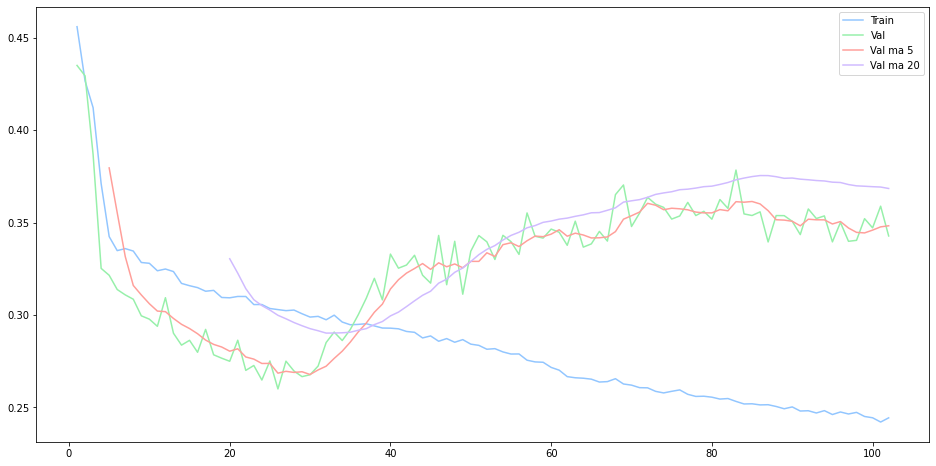

In [ ]:
ma1 = 5
ma2 = 20

tdf[f"val_ma{ma1}"] = tdf["val_loss"].rolling(window=ma1).mean()
tdf[f"val_ma{ma2}"] = tdf["val_loss"].rolling(window=ma2).mean()*1.05

plt.plot(tdf["train_loss"], label="Train")
plt.plot(tdf["val_loss"], label="Val")
plt.plot(tdf[f"val_ma{ma1}"], label=f"Val ma {ma1}")
plt.plot(tdf[f"val_ma{ma2}"], label=f"Val ma {ma2}")
plt.legend();

In [ ]:
class M4Monthly(Dataset):
    def __init__(self, filepath, n_series=None):
        self.series = pd.read_feather(filepath).set_index("Name").astype("float32")

        self.shape = self.series.shape + (1, )

        if n_series:
            self.series = self.series.sample(n=n_series, replace=False)

    def __len__(self):
        return len(self.series)

    def __getitem__(self, idx):
        return self.series.iloc[idx, :].to_numpy().reshape(self.shape[1:])

In [ ]:
def get_dataloaders(run):
    defpath = "/content/artifacts/m4-month-40:v3/m4-month-40.feather"
    # Query W&B for an artifact and mark it as input to this run
    conf = run.config
    artifact = run.use_artifact(conf.dataartifact)
    # Download the artifact's contents
    artifact_path = artifact.get_path(f"{conf.dataartifact.split(':')[0]}.feather").download()
    artifact_path = artifact_path if len(artifact_path) > 1 else defpath

    m4dataset = M4Monthly(artifact_path, n_series=conf.n_series)
    l = len(m4dataset)
    split = (l - l // 10, l // 10)
    train_data, val_data = random_split(m4dataset, lengths=split)

    train_loader = DataLoader(train_data, batch_size=conf.batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=conf.batch_size, shuffle=True)

    seq_len, num_features = m4dataset.shape[1:]

    return train_loader, val_loader, seq_len, num_features